## Импорты

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.2 MB/s eta 0:00:00


In [ ]:
!pip3 install pytorch_lightning torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 24.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import mode
from sklearn.tree import DecisionTreeClassifier, plot_tree

import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
d = pd.read_csv('/content/drive/MyDrive/shiftData/train.csv')

## Train/Test data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/shiftData/train.csv')
dataTest = pd.read_csv('/content/drive/MyDrive/shiftData/test.csv')
full = pd.concat([data, dataTest])

In [ ]:
data.shape

(261384, 122)

## installments_payments

In [ ]:
pays = pd.read_csv('/content/drive/MyDrive/shiftData/installments_payments.csv')
pays['due_entry'] = pays['installment_due_date'] - pays['days_entry_payment']
pays['payments'] = pays['first_payment_requested'] - pays['payment']

NameError: ignored

In [ ]:
p_grp = pays.groupby('reco_id_last', as_index=False).aggregate({'number_of_instalment_ver': lambda x: x.nunique(),
                                                                'due_entry': 'sum',
                                                                'number_of_instalment_num': 'mean',
                                                                'payments' : 'sum'
                                                                })

## previous_loan

In [ ]:
loan = pd.read_csv('/content/drive/MyDrive/shiftData/previous_loan.csv')
loan_pay = pd.merge(loan, p_grp, on='reco_id_last', how='left')

In [ ]:
loan_grp = loan_pay.groupby('reco_id_curr', as_index=False).aggregate({'reco_id_last': 'count',
                                                                       'loan_body':'sum',
                                                                       'days_decision':'mean',
                                                                       'loan_body_requested':'sum',
                                                                       'annuity_payment':'mean',
                                                                       'number_of_instalment_ver':'sum',
                                                                       'due_entry': 'sum',
                                                                       'number_of_instalment_num': 'sum',
                                                                       'first_payment':'sum',
                                                                       'hour_of_approval_process_start':'mean',
                                                                       'last_day_app_f':'sum',
                                                                       'down_payment_rate':'mean',
                                                                       'cash_loan_purpose_name': lambda x: list(x).count('Everyday expenses'),
                                                                       'cash_loan_purpose_name': lambda x: list(x).count('Refusal to name the goal'),
                                                                       'days_decision': 'mean',
                                                                       'annuity_payment': 'mean',
                                                                       'loan_body_requested': 'sum',
                                                                       'contract_status_name': lambda x: list(x).count('Refused'),
                                                                       'contract_status_name': lambda x: list(x).count('Approved'),
                                                                       'payment_count': 'max',
                                                                       'yield_group_name' : lambda x: list(x).count('high'),
                                                                       'days_first_drawing':'sum',
                                                                       'days_first_due': 'sum',
                                                                       'last_due_date': 'sum',
                                                                       'termination_date':'sum',
                                                                       'payments': 'sum'
                                                                       })

In [ ]:
loan_grp['due_term'] = loan_grp['last_due_date'] - loan_grp['termination_date']
loan_grp['days_diff'] = loan_grp['days_first_drawing'] - loan_grp['days_first_due']

In [ ]:
datLoan = pd.merge(full, loan_grp, on='reco_id_curr', how='left')
datLoan['diff'] = datLoan['loan_body_y'] - datLoan['loan_body_requested']

## BKI_balance

In [ ]:
bki = pd.read_csv('/content/drive/MyDrive/shiftData/bki.csv')

In [ ]:
balance = pd.read_csv('/content/drive/MyDrive/shiftData/bki_balance.csv')

In [ ]:
balance_grp = balance.groupby('reco_bureau_id', as_index=False).aggregate({'stat_for_bureau':
                                                                           lambda x: sum(list(x).count(i) for i in '12345') })

In [ ]:
bki_balance = pd.merge(bki, balance_grp, on='reco_bureau_id', how='left')

## BKI

In [ ]:
bki_balance['credit_sum_overdue_coeff'] = bki_balance['credit_sum_overdue'] * bki_balance['days_credit_update']

In [ ]:
bki_grp = bki_balance.groupby('reco_id_curr', as_index=False).aggregate({'credit_day_overdue': 'sum',
                                                      'days_credit_enddate':'sum',
                                                      'credit_prolong_count': 'sum',
                                                      'credit_sum': 'sum',
                                                      'credit_sum_debt':'sum',
                                                      'credit_sum_overdue': 'sum',
                                                      'annuity_payment': 'mean', 'stat_for_bureau':'sum',
                                                      'days_credit':'max',
                                                      'days_enddate_fact': 'max',
                                                      'credit_limit_max_overdue': 'sum',
                                                      'days_credit_update':'mean',
                                                      'credit_sum_overdue_coeff' : 'sum'
                                                      })

In [ ]:
datBki = pd.merge(datLoan, bki_grp, on='reco_id_curr', how='left')

## Cash Pos Balance

In [ ]:

cash = pd.read_csv('/content/drive/MyDrive/shiftData/cash_pos_balance.csv')

In [ ]:
cash['dpd_diff'] = cash['reco_dpd'] - cash['reco_dpd_def']

In [ ]:
loanCash = cash.groupby('reco_id_curr', as_index=False).aggregate({'installment_future_count': 'sum',
                                                                  'installment_future_count' : 'mean',
                                                                  'contract_status_name': lambda x: list(x).count('Completed'),
                                                                  'reco_dpd': 'sum',
                                                                   'dpd_diff' : 'sum'})

In [ ]:
datCash = pd.merge(datBki, loanCash, on='reco_id_curr', how='left')

## Credit card balance

In [ ]:
card = pd.read_csv('/content/drive/MyDrive/shiftData/credit_card_balance.csv')

In [ ]:
card_grp = card.groupby('reco_id_curr', as_index=False).aggregate({'balance': 'mean',
                                                                  'credit_limit':'mean',
                                                                  'minimal_payment':'sum',
                                                                  'payment_total_now':'sum',
                                                                  'contract_status_name':  lambda x: list(x).count('Refused'),
                                                                  'reco_dpd': 'sum',
                                                                  'reco_dpd_def':'sum',
                                                                   'drawings':'max',
                                                                   'receivable' : 'mean',
                                                                   'drawings_count':'sum',
                                                                   'drawings_pos_count':'sum',
                                                                   'installment_mature_cum_count':'sum'
                                                                   })

In [ ]:
card_grp['recoDiff'] = card_grp['reco_dpd'] - card_grp['reco_dpd_def']

In [ ]:
datCard = pd.merge(datCash, card_grp, on='reco_id_curr', how='left')

## Full Data Prerprocessing

In [ ]:
n = data.shape[0]
col_names = datCard.columns
cat_cols = list(datCard.dtypes[datCard.dtypes == 'object'].index) #names of categorical columns
dig_cols = list(set(col_names) - set(cat_cols)) #digital columns

In [ ]:
#get rid of missed values
datNans = pd.DataFrame()
for dif in dig_cols:
    datNans[dif] = datCard[dif].fillna(np.mean(datCard[dif]))
for cat in cat_cols:
    datNans[cat] = datCard[cat].fillna('unstated')

<ipython-input-29-79a82eeb0128>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  datNans[dif] = datCard[dif].fillna(np.mean(datCard[dif]))
<ipython-input-29-79a82eeb0128>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  datNans[cat] = datCard[cat].fillna('unstated')


In [ ]:
std = StandardScaler()
datNans[dig_cols] = std.fit_transform(datNans[dig_cols])

In [ ]:
X = pd.get_dummies(datNans.drop('target', axis=1))
y = full['target']

In [ ]:
XShort = X.loc[:, colls]

In [ ]:
# X = datNans.drop('target', axis=1)
# y = full['target']

In [ ]:
X, X_test = X[:n], X[n:]
y = y[:n]

## CatBoostClassifier

In [ ]:
model2 = CatBoostClassifier()

In [ ]:
model2.fit(X, y)

Learning rate set to 0.080364
0:	learn: 0.6154225	total: 172ms	remaining: 2m 51s
1:	learn: 0.5470127	total: 271ms	remaining: 2m 15s
2:	learn: 0.4941103	total: 388ms	remaining: 2m 9s
3:	learn: 0.4511354	total: 482ms	remaining: 2m
4:	learn: 0.4172513	total: 588ms	remaining: 1m 56s
5:	learn: 0.3874909	total: 753ms	remaining: 2m 4s
6:	learn: 0.3665113	total: 859ms	remaining: 2m 1s
7:	learn: 0.3473112	total: 986ms	remaining: 2m 2s
8:	learn: 0.3325551	total: 1.08s	remaining: 1m 59s
9:	learn: 0.3193238	total: 1.17s	remaining: 1m 55s
10:	learn: 0.3084400	total: 1.27s	remaining: 1m 54s
11:	learn: 0.3000156	total: 1.4s	remaining: 1m 55s
12:	learn: 0.2924374	total: 1.5s	remaining: 1m 54s
13:	learn: 0.2865242	total: 1.59s	remaining: 1m 52s
14:	learn: 0.2818154	total: 1.7s	remaining: 1m 51s
15:	learn: 0.2774378	total: 1.81s	remaining: 1m 51s
16:	learn: 0.2737162	total: 1.92s	remaining: 1m 50s
17:	learn: 0.2709280	total: 2.04s	remaining: 1m 51s
18:	learn: 0.2680731	total: 2.14s	remaining: 1m 50s
19:

In [ ]:
predTest = model2.predict_proba(X_test)
ans = pd.DataFrame(dataTest['reco_id_curr'])
ans['target'] = predTest.T[1]
ans.to_csv('./answer.csv', index=False)

Конец основной части

----------------------------------------------------

## RandomForest

In [ ]:
model1 = RandomForestClassifier(n_estimators=200, min_samples_split=20, min_samples_leaf=20)

In [ ]:
model1.fit(X, y)

RandomForestClassifier(min_samples_leaf=20, min_samples_split=20,
                       n_estimators=200)

In [ ]:
pd.Series(model1.feature_importances_, index= X.columns).sort_values(ascending=False)[:30] #30 наиболее значимых признаков

external_source_2                   0.093649
external_source_3                   0.090361
external_source_1                   0.033033
days_birth                          0.028279
last_phone_number_change            0.025369
days_employed                       0.025293
publication_timestamp               0.022736
registration_timestamp              0.020392
loan_body_x                         0.020226
installment_future_count            0.019499
reco_id_curr                        0.018961
annuity_payment_x                   0.018931
goods_price                         0.018830
population_relative_region          0.015820
income                              0.013130
days_credit                         0.012539
hour_of_approval_process_start_x    0.011127
days_credit_update                  0.010940
days_credit_enddate                 0.010923
days_decision                       0.009677
loan_body_y                         0.008473
credit_sum                          0.008369
credit_sum

In [ ]:
top10 = list(pd.Series(model1.feature_importances_, index=X.columns).sort_values(ascending=False)[:30].index)

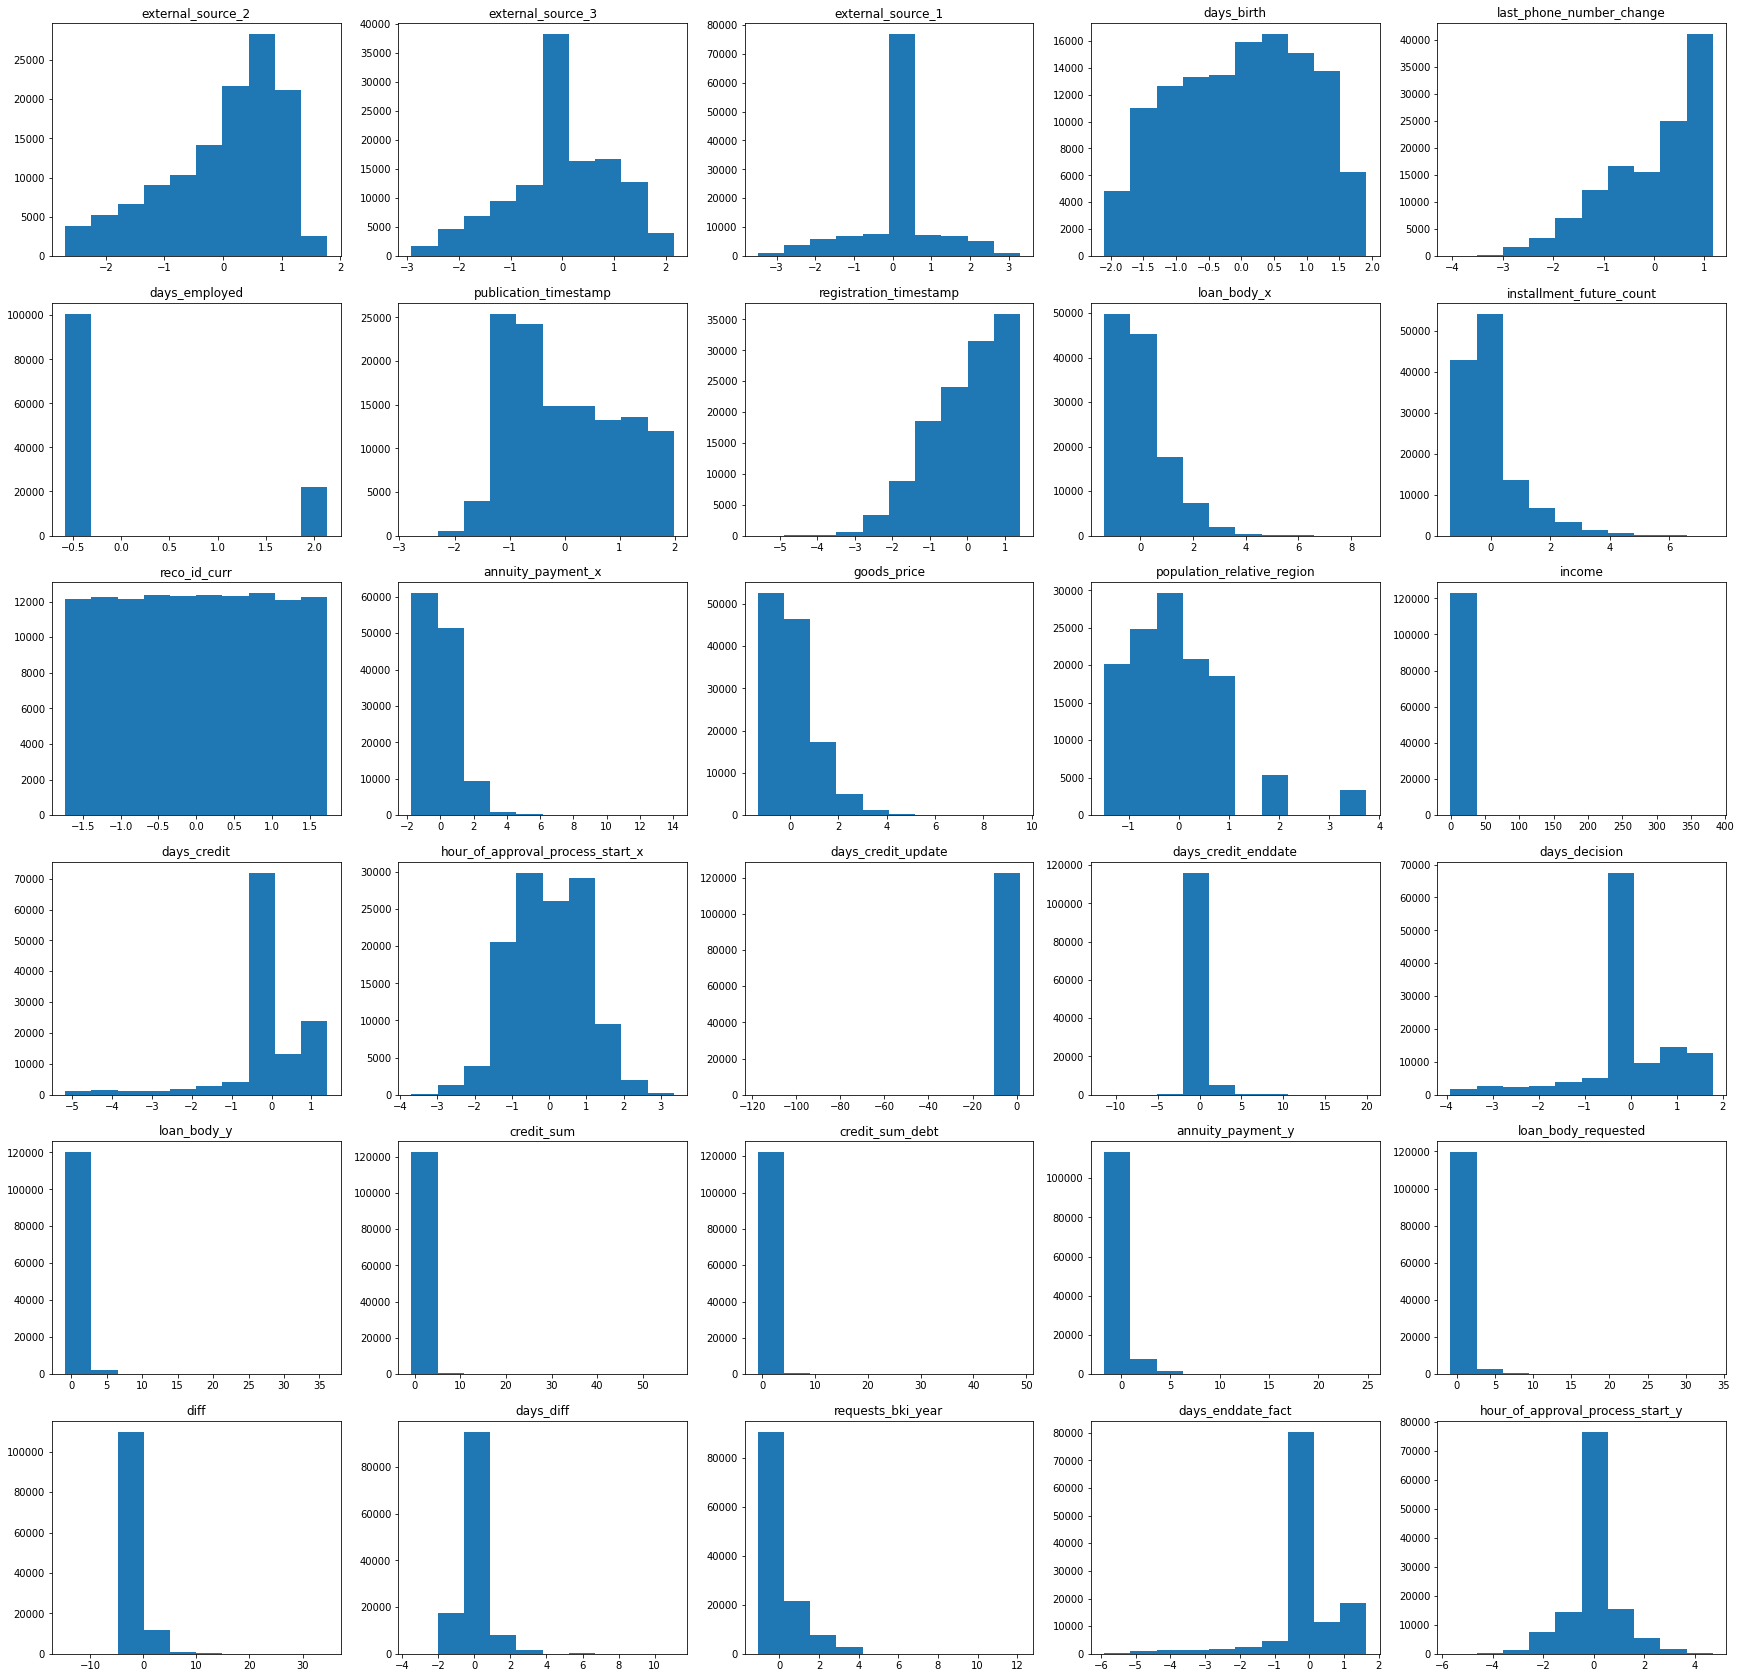

In [ ]:
fig, ax = plt.subplots(6, 5, figsize=(30,30))
ax = ax.ravel()

for i in range(len(top10)):
    ax[i].hist(X.loc[:, top10[i]])
    ax[i].set_title(top10[i])
fig.show()

In [ ]:
cats = ['income_type_name',
       'gender',
       'education_type_name']

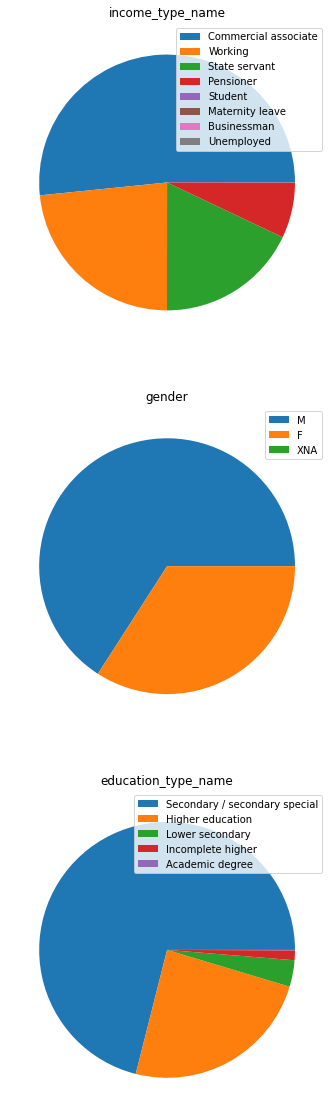

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(20,20))
ax = ax.ravel()

for i in range(len(cats)):
    ax[i].pie(full.loc[:, cats[i]].value_counts())
    ax[i].legend(full.loc[:, cats[i]].unique(), loc='best')
    ax[i].set_title(cats[i])
fig.show()

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(data=datNans, x='external_source_2', kde=True, hue="target")

<IPython.core.display.Javascript object>

## Decision tree

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model4 = DecisionTreeClassifier(max_depth = 8, min_samples_split=100, min_samples_leaf=100)

In [ ]:
model4.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=100, min_samples_split=100)

In [ ]:
roc_auc_score(y_valid, model4.predict_proba(X_valid).T[1])

0.710915214384135

In [ ]:
plt.figure(figsize=(30, 10))
plot_tree(model4, feature_names=list(X_train.columns))

<IPython.core.display.Javascript object>

[Text(0.382408038147139, 0.9444444444444444, 'external_source_3 <= -1.404\ngini = 0.149\nsamples = 85977\nvalue = [79013, 6964]'),
 Text(0.12142370572207084, 0.8333333333333334, 'external_source_2 <= -1.287\ngini = 0.31\nsamples = 9268\nvalue = [7490, 1778]'),
 Text(0.05722070844686648, 0.7222222222222222, 'external_source_3 <= -1.894\ngini = 0.442\nsamples = 1747\nvalue = [1172, 575]'),
 Text(0.04632152588555858, 0.6111111111111112, 'publication_timestamp <= 1.553\ngini = 0.472\nsamples = 916\nvalue = [566, 350]'),
 Text(0.04087193460490463, 0.5, 'installment_future_count <= 0.098\ngini = 0.461\nsamples = 816\nvalue = [522, 294]'),
 Text(0.027247956403269755, 0.3888888888888889, 'gender_M <= 0.5\ngini = 0.439\nsamples = 585\nvalue = [395, 190]'),
 Text(0.01634877384196185, 0.2777777777777778, 'days_birth <= 0.686\ngini = 0.411\nsamples = 370\nvalue = [263, 107]'),
 Text(0.010899182561307902, 0.16666666666666666, 'population_relative_region <= -0.175\ngini = 0.34\nsamples = 207\nvalue 

## Оценка качества полученной модели

In [ ]:
model2 = CatBoostClassifier()
model2.fit(X_train, y_train)

Learning rate set to 0.069011
0:	learn: 0.6261300	total: 176ms	remaining: 2m 55s
1:	learn: 0.5679489	total: 300ms	remaining: 2m 29s
2:	learn: 0.5198943	total: 447ms	remaining: 2m 28s
3:	learn: 0.4792715	total: 567ms	remaining: 2m 21s
4:	learn: 0.4472151	total: 696ms	remaining: 2m 18s
5:	learn: 0.4186158	total: 830ms	remaining: 2m 17s
6:	learn: 0.3920199	total: 990ms	remaining: 2m 20s
7:	learn: 0.3705398	total: 1.13s	remaining: 2m 20s
8:	learn: 0.3550946	total: 1.28s	remaining: 2m 21s
9:	learn: 0.3424407	total: 1.4s	remaining: 2m 19s
10:	learn: 0.3293919	total: 1.47s	remaining: 2m 12s
11:	learn: 0.3185819	total: 1.56s	remaining: 2m 8s
12:	learn: 0.3100719	total: 1.65s	remaining: 2m 5s
13:	learn: 0.3022669	total: 1.72s	remaining: 2m 1s
14:	learn: 0.2958538	total: 1.8s	remaining: 1m 58s
15:	learn: 0.2904046	total: 1.88s	remaining: 1m 55s
16:	learn: 0.2853268	total: 1.97s	remaining: 1m 54s
17:	learn: 0.2815407	total: 2.05s	remaining: 1m 51s
18:	learn: 0.2785095	total: 2.13s	remaining: 1m 5

Из рисунка рисунка видно, что наибольшее влияние оказали признаки external_source_2 и external_source_3, можно предположить, что это какой-то скор, составленный по клиентам, (исходя из их активностей или каких-то других признаков)

In [ ]:
y_pred_proba = model2.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_pred_proba)
auc = roc_auc_score(y_valid, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)

In [ ]:
conf_matrix = confusion_matrix(y_valid, model2.predict(X_valid))
sns.heatmap(conf_matrix, annot=True, cmap='Blues')

In [ ]:
X.shape

(15560, 307)

In [ ]:
from collections import defaultdict, namedtuple

import pytorch_lightning as pl
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchmetrics.classification import MulticlassAccuracy

mca = MulticlassAccuracy(num_classes=10, average=None)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_tr = torch.Tensor(np.array(X_train))

In [ ]:
X_train

(209107, 305)

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, X_train, y_train):
        self.dataset = X_train
        self.ans = y_train

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]#.type(torch.LongTensor)
        label = self.ans.iloc[idx]
        return image, label

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataloader = DataLoader(
    CustomImageDataset(X_train, y_train),
    batch_size=128,
    shuffle=True,
    num_workers=4
)


val_dataloader = DataLoader(
    CustomImageDataset(X_test, y_test),
    batch_size=128,
    num_workers=4
)

In [ ]:
X_train.iloc[0, :]

document_15_flag                -3.480198e-02
annuity_payment_y               -8.005421e-01
requests_bki_week               -1.805048e-01
drawings                        -1.535011e+00
median_elevator_count           -1.510179e-16
                                     ...     
mode_walls_material_Wooden       0.000000e+00
mode_walls_material_unstated     1.000000e+00
emergency_state_mode_No          0.000000e+00
emergency_state_mode_Yes         0.000000e+00
emergency_state_mode_unstated    1.000000e+00
Name: 129013, Length: 305, dtype: float64

In [ ]:
class EasyNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # вытягиваем матрицу (картинка - это матрица) в вектор (одномерный массив)
        self.linear1 = nn.Linear(305, 128) # полносвязный слой с 28*28 входными и 128 выходными нейронами
        # self.relu = nn.ReLU() # функция активации ReLU
        self.relu = F.selu
        self.linear2 = nn.Linear(128, 2)

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)

        return x

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._forward(images)

        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target) # вычисляем ошибку модели

            self.targets = torch.cat((self.targets, target.cpu()), 0) # задаем значения целевой переменной

            pred = torch.argmax(output, dim=-1) # переводим предсказания модели в классы
            self.preds = torch.cat((self.preds, pred.cpu()), 0)

            self.accuracy = mca(self.preds.long(), self.targets.long()) # вычисляем accuracy по всем текущим значениям

            return output, loss

        return output

    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

In [ ]:
LossInfo = namedtuple(
    "LossInfo",
    ["full_train_losses", "train_epoch_losses", "eval_epoch_losses"]
)

EPOCHS = 10 # число эпох
LR = 0.001 # learning rate

In [ ]:
# 1) create a LightningModule
class SimpleModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.NAdam(self.parameters(), lr=self.learning_rate) # вариант градиентного спуска, который мы используем
        return optimizer

    def training_step(self, train_batch, batch_idx): # шаг обучения: вычисляем лосс на батче
        images, target = train_batch
        _, loss = self.model(images, target)
        self.log("train_loss", loss, prog_bar=True)  # сохраняет логи в папку
        return loss

    def validation_step(self, val_batch, batch_idx): # шаг валидации - аналогичный
        images, target = val_batch
        _, loss = self.model(images, target)
        self.log("val_loss", loss, prog_bar=True)

    def test_step(self, test_batch, batch_idx): # шаг тестирования - вычисляем ту метрику или функцию потерь, которую хотим
        images, target = test_batch

        preds = self.model(images)
        pred_classes = torch.argmax(preds, dim=-1) # переводим предсказания модели в классы

        accuracy = mca(pred_classes.cpu(), target.cpu()).mean()

        self.log("test_accuracy", accuracy, prog_bar=True)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # если есть gpu, то gpu
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'

In [ ]:
# 2) create module

model = EasyNet().to(device) # объявляем сеть, переносим ее на gpu

module = SimpleModule( # объявляем модуль для обучения сети
    model,
    learning_rate=LR
)

# 3) create Trainer and train (±30 seconds on gpu)
trainer = pl.Trainer( # выбираем параметры обучения
    accelerator=accelerator,
    max_epochs=10
)

trainer.fit(module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params
----------------------------------
0 | model | EasyNet | 39.4 K
----------------------------------
39.4 K    Trainable params
0         Non-trainable params
39.4 K    Total params
0.158     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: ignored

In [ ]:
trainer.test(module, dataloaders=val_dataloader)

In [ ]:
y.iloc[1]

0.0

In [ ]:
nn.Flatten(X_train.iloc[0,:])

Flatten(
  start_dim=document_15_flag                -3.480198e-02
  annuity_payment_y               -8.005421e-01
  requests_bki_week               -1.805048e-01
  drawings                        -1.535011e+00
  median_elevator_count           -1.510179e-16
                                       ...     
  mode_walls_material_Wooden       0.000000e+00
  mode_walls_material_unstated     1.000000e+00
  emergency_state_mode_No          0.000000e+00
  emergency_state_mode_Yes         0.000000e+00
  emergency_state_mode_unstated    1.000000e+00
  Name: 129013, Length: 305, dtype: float64, end_dim=-1
)